# Import datas

In [1]:
TRUE_MU = 40.
import lzma
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import jax.numpy as jnp
import os
path = os.getcwd().split("/")

path = '/'.join(path[:path.index("ABC-SBI")+1])
print(path)
os.chdir(path)
PATH_RESULTS = os.getcwd()+"/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/notebook_results/mu_{:.3}".format(TRUE_MU)
with lzma.open(PATH_RESULTS +'/params.xz', "rb") as f:
    PARAMS = pickle.load(f)
    
with lzma.open(PATH_RESULTS +'/thetas_abc.xz', "rb") as f:
    THETAS_ABC = pickle.load(f)
df = pd.read_csv(PATH_RESULTS + '/results.csv')

/Users/antoineluciano/Documents/Recherche/ABC-SBI


In [2]:
def true_posterior_sample(key, TRUE_DATA, N_SAMPLE):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(TRUE_DATA))/(SIGMA0**2*len(TRUE_DATA) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(TRUE_DATA)/SIGMA**2)
    return random.normal(key, (N_SAMPLE,))*jnp.sqrt(sigma2_post)+ mu_post


def true_posterior_pdf(theta, TRUE_DATA):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * jnp.sum(TRUE_DATA))/(SIGMA0**2*len(TRUE_DATA) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(TRUE_DATA)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = jnp.sqrt(sigma2_post)).pdf(theta)

Loading the informations of the model

In [3]:
# Get the columns that start with 'xobs'
xobs_columns = [col for col in df.columns if col.startswith('xobs')]

# Calculate N_DATA
N_DATA = len(xobs_columns)

# Get the values of these columns in an array
TRUE_DATA = np.array(df[xobs_columns].values[0])
TRUE_MU = np.array(df["true_theta_1"].values[0])
SIGMA0 = np.array(df["sigma0"].values[0])
MU0 = np.array(df["mu0"].values[0])
SIGMA = np.array(df["sigma"].values[0])
PRIOR = norm(loc=MU0, scale=SIGMA0)
print("TRUE_MU:", TRUE_MU)

print("N_DATA:", N_DATA)
print("TRUE_DATA:", TRUE_DATA)

TRUE_MU: 40.0
N_DATA: 5
TRUE_DATA: [38.541805 37.952957 42.04734  41.16841  39.024162]


# Running Time

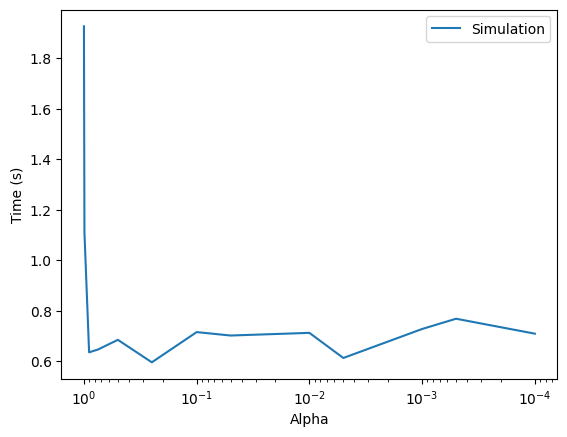

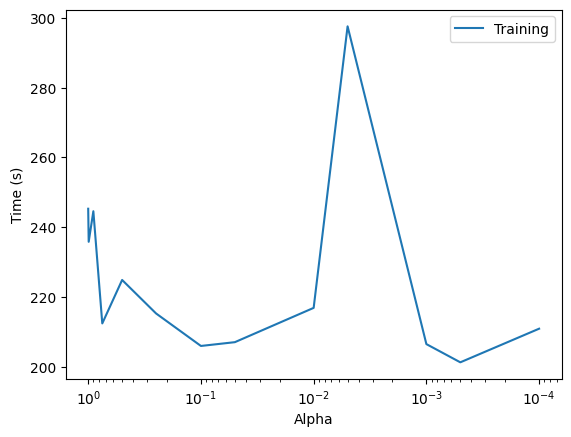

In [4]:
alphas = np.sort(np.unique(df["alpha"].values))[::-1]
time_simulation = np.array([df[(df["alpha"] == a) & (df["metric"] == "TIME_SIMULATION")]["metric_value"].values[0] for a in alphas])
time_training = np.array([df[(df["alpha"] == a) & (df["metric"] == "TIME_TRAINING")]["metric_value"].values[0] for a in alphas])

plt.plot(alphas, time_simulation, label="Simulation")
plt.xlabel("Alpha")
plt.ylabel("Time (s)")
plt.gca().set_xscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()


plt.plot(alphas, time_training, label="Training")
plt.xlabel("Alpha")
plt.ylabel("Time (s)")
plt.gca().set_xscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()


# Posterior Error Metrics

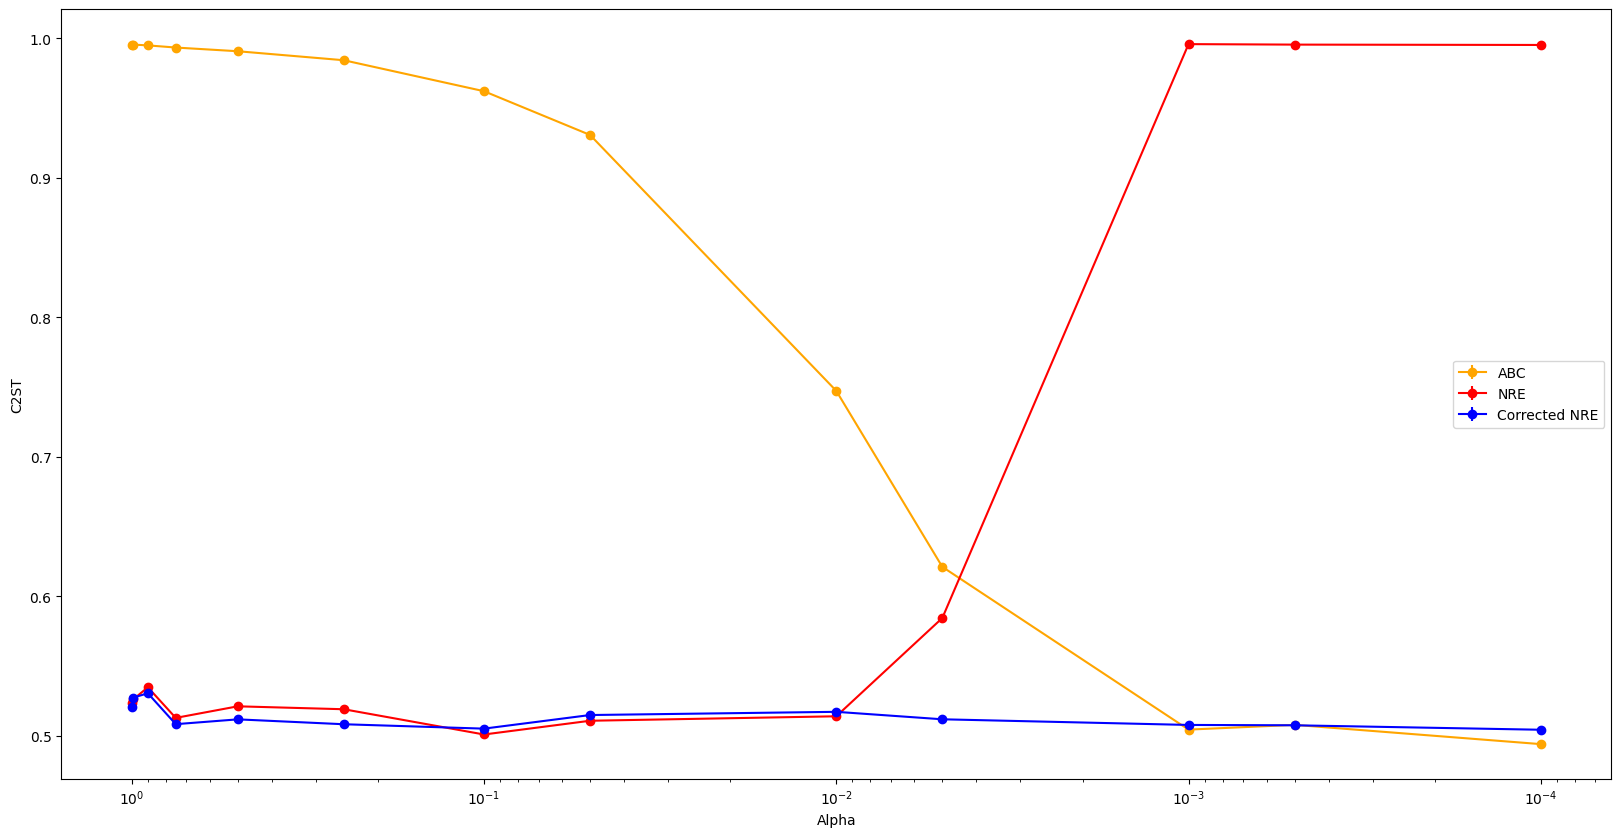

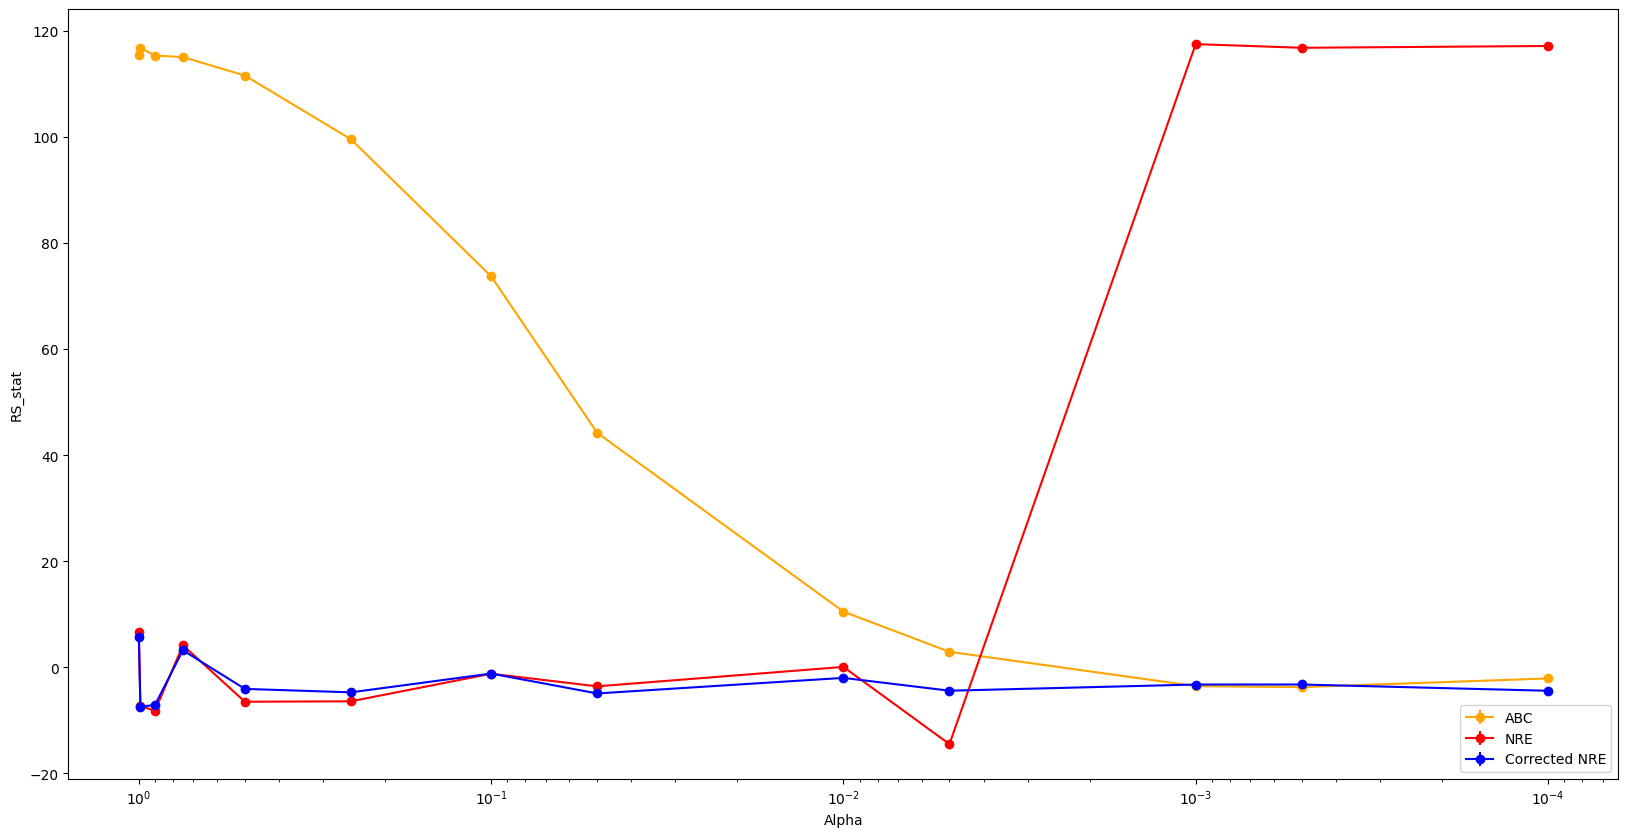

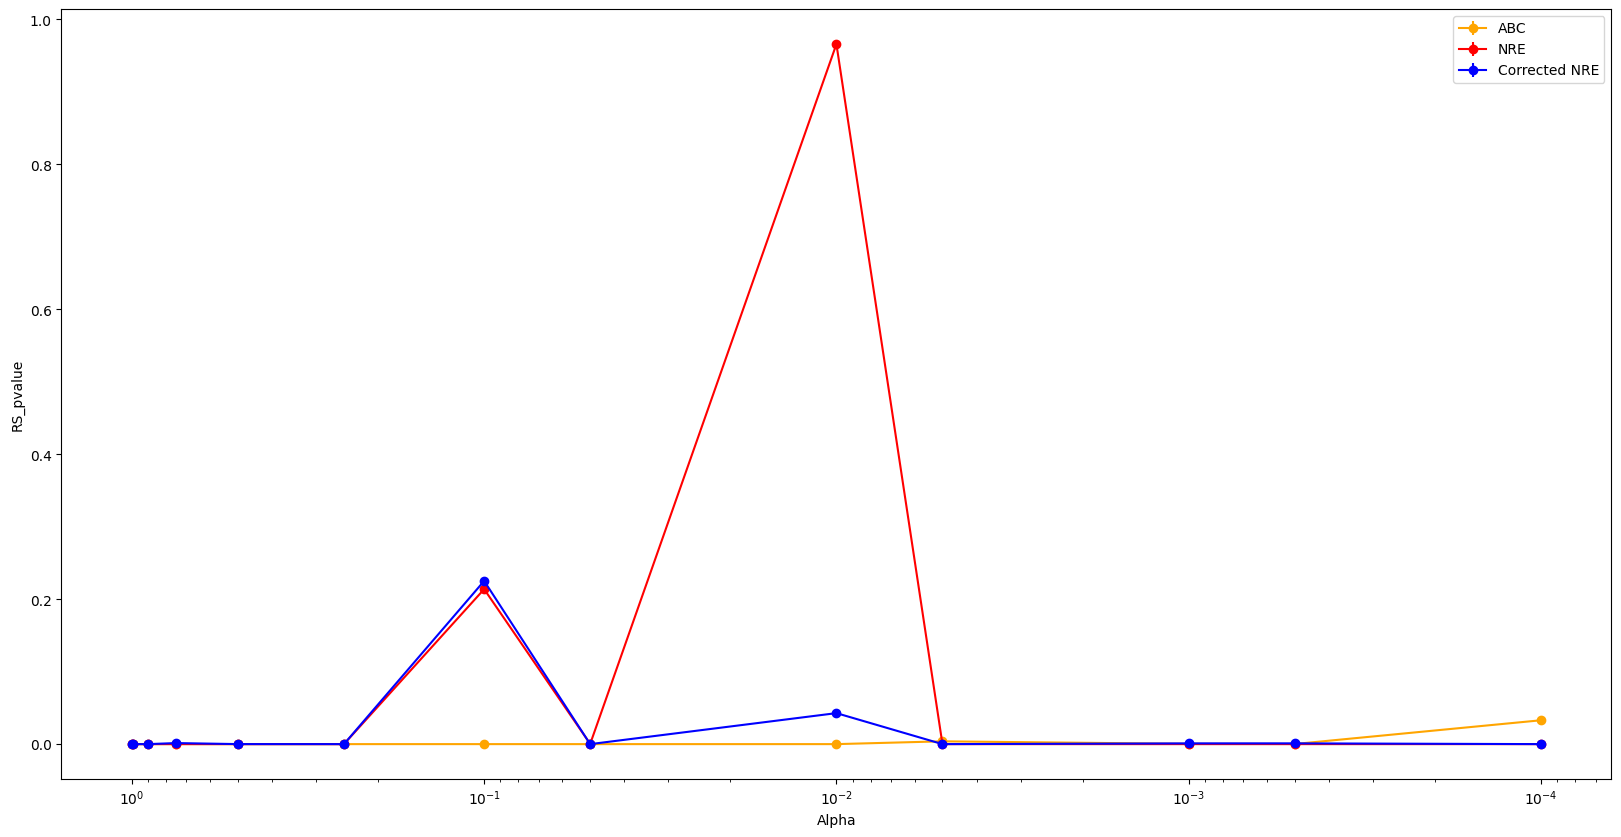

In [5]:
for metric in ["C2ST", "RS_stat", "RS_pvalue"]:
    alphas = np.sort(np.unique(df["alpha"].values))[::-1]
    abc = np.array([df[(df["alpha"] == a) & (df["metric"] == metric) & (df["method"]=="ABC")]["metric_value"].values for a in alphas])
    nre = np.array([df[(df["alpha"] == a) & (df["metric"] == metric) & (df["method"]=="NRE")]["metric_value"].values for a in alphas])
    corrected_nre = np.array([df[(df["alpha"] == a) & (df["metric"] == metric) & (df["method"]=="CORRECTED_NRE")]["metric_value"].values for a in alphas])
    f, ax = plt.subplots(figsize=(20, 10))
    ax.errorbar(alphas, abc.mean(axis = 1), yerr = abc.std(axis = 1), label = "ABC", fmt = 'o-', color= "orange")
    ax.errorbar(alphas, nre.mean(axis = 1), yerr = nre.std(axis = 1), label = "NRE", fmt = 'o-', color= "red")
    ax.errorbar(alphas, corrected_nre.mean(axis = 1), yerr = corrected_nre.std(axis = 1), label = "Corrected NRE", fmt = 'o-', color= "blue")
    ax.set_xlabel("Alpha")
    ax.set_ylabel(metric)
    ax.set_xscale('log')
    ax.invert_xaxis()
    ax.legend()
    plt.show()

# Posterior comparison plots

## By importing the pdf values

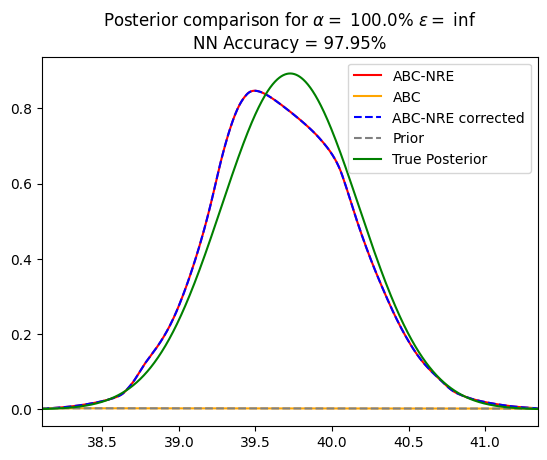

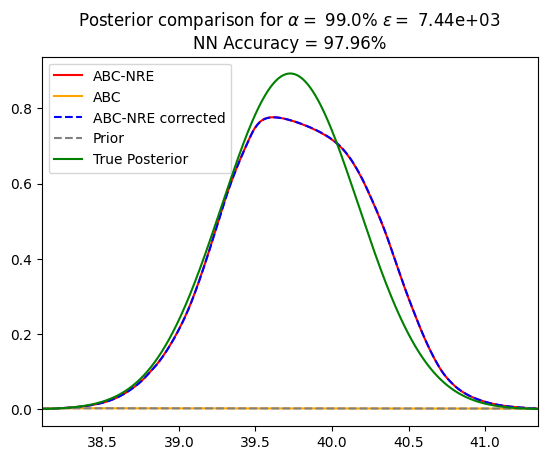

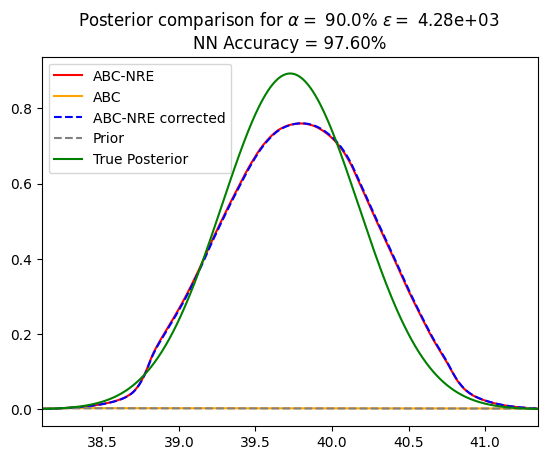

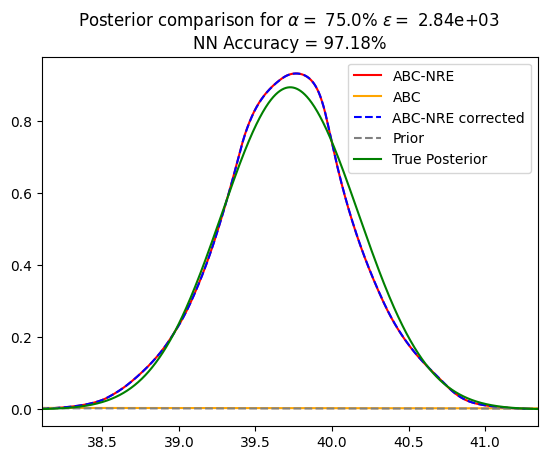

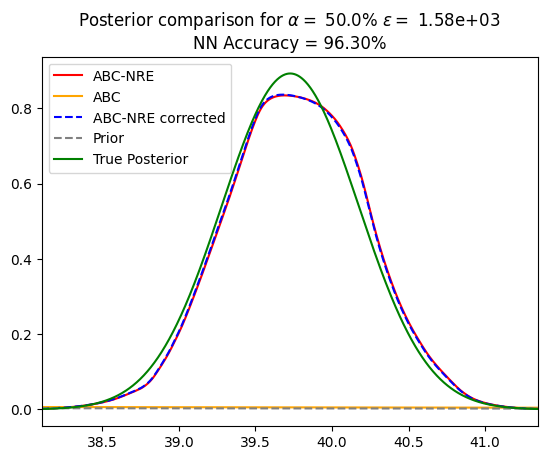

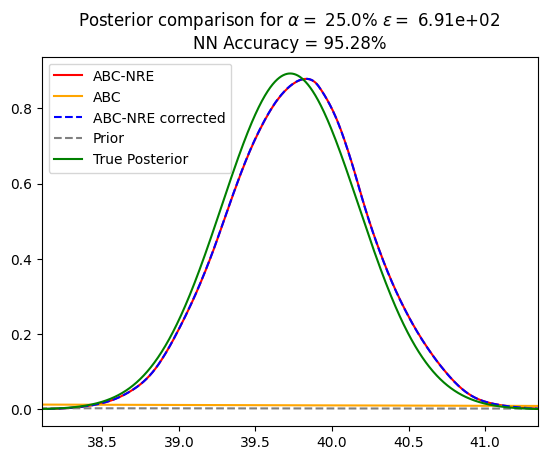

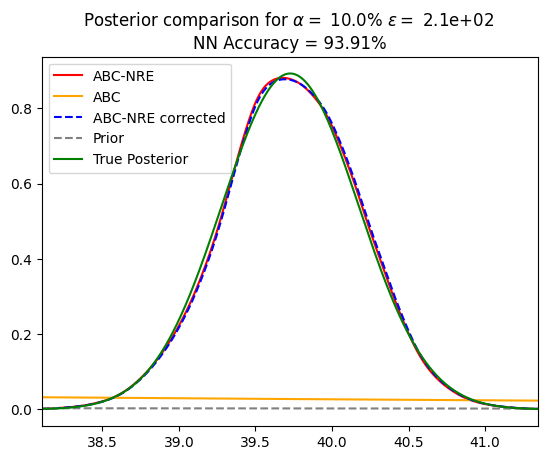

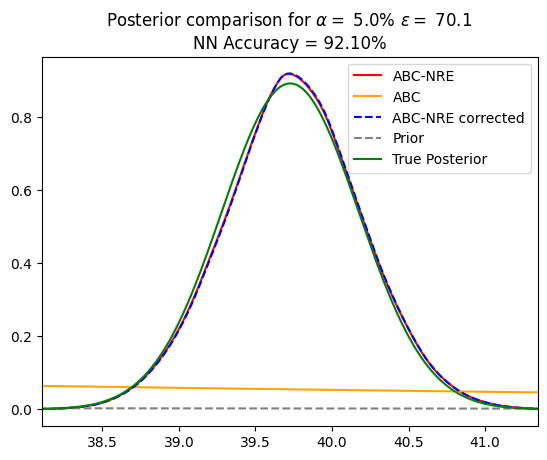

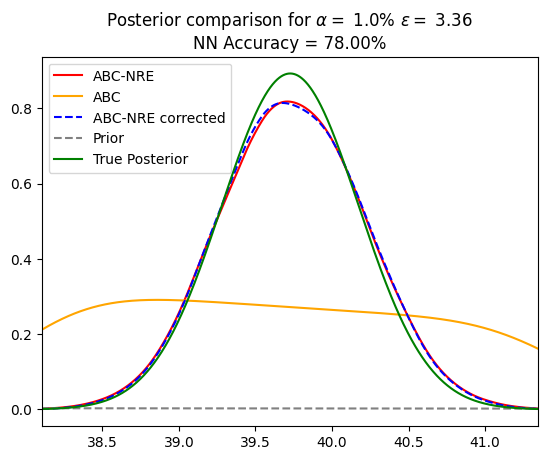

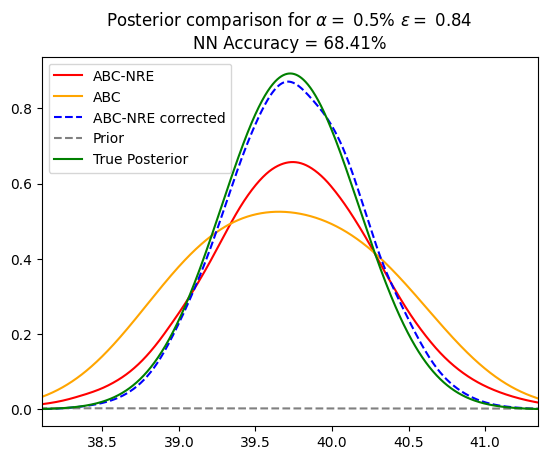

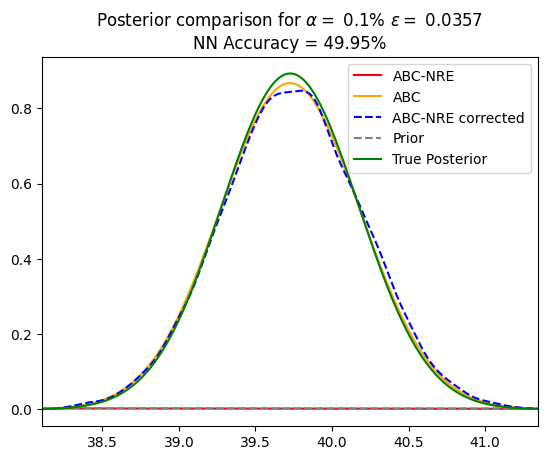

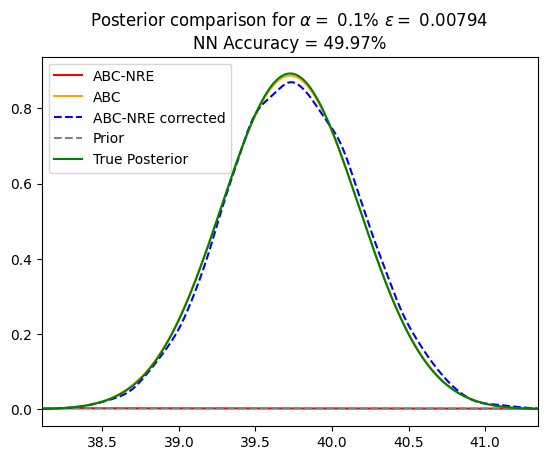

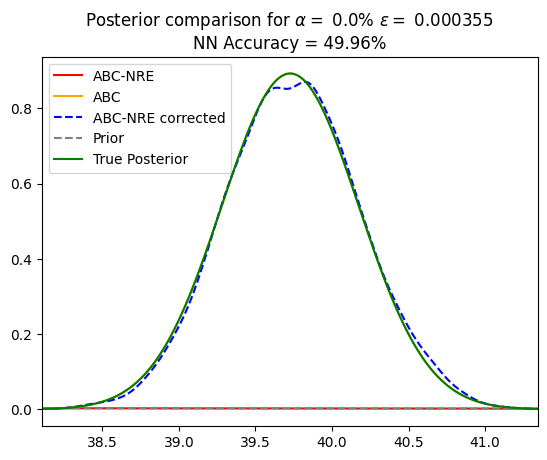

In [6]:
epsilons = np.sort(np.unique(df["epsilon"].values))[::-1]
for alpha, epsilon in zip(alphas, epsilons):
    df_figure = pd.read_csv(PATH_RESULTS + f'/plot_posterior_comparison_{alpha}_{epsilon:.3}.csv'.format(alpha=alpha, epsilon=epsilon))
    
    test_accuracy = df[(df["alpha"] == alpha) & (df["epsilon"] == epsilon) & (df["metric"] == "NN_TEST_ACCURACY")]["metric_value"].values[0]
    grid_nre = df_figure["grid_nre"]
    pdf_nre = df_figure["pdf_nre"]
    grid_pseudo = df_figure["grid_pseudo"]
    pdf_pseudo = df_figure["pdf_pseudo"]
    grid_nre_corrected = df_figure["grid_nre_corrected"]
    pdf_nre_corrected = df_figure["pdf_nre_corrected"]
    grid_prior = df_figure["grid_prior"]
    pdf_prior = df_figure["pdf_prior"]
    grid_true = df_figure["grid_true"]
    pdf_true = df_figure["pdf_true"]
    
    Z_pseudo = np.trapz(pdf_pseudo, grid_pseudo)
    Z_nre = np.trapz(pdf_nre, grid_nre)
    Z_nre_corrected = np.trapz(pdf_nre_corrected, grid_nre_corrected)
    
    plt.plot(grid_nre, pdf_nre/Z_nre, label = 'ABC-NRE', color = "red")
    plt.plot(grid_pseudo, pdf_pseudo/Z_pseudo, label = "ABC", color = "orange")
    plt.plot(grid_nre_corrected, pdf_nre_corrected/Z_nre_corrected, label = "ABC-NRE corrected", color = "blue", linestyle = "--")

    plt.plot(grid_prior, pdf_prior, label = 'Prior', color = "grey", linestyle = "--")
    plt.plot(grid_true, pdf_true, label = 'True Posterior', color = "green")
    plt.xlim(np.min(grid_true), np.max(grid_true))
    plt.title(f"Posterior comparison for $\\alpha =$ {alpha:1.1%} $\\epsilon =$ {epsilon:.3} \nNN Accuracy = {test_accuracy:.2%}")
    plt.legend()
    plt.show()

## By recreating them

Use the `PARAMS` and `THETAS_ABC` pickles to recreate the plot with **`plot_posterior_comparison`** in **`functions.plots`**

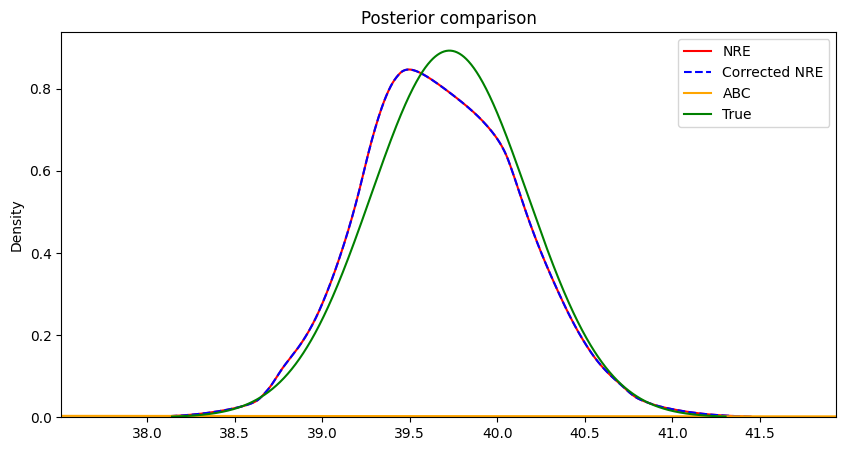

FIGURE CREATED at 


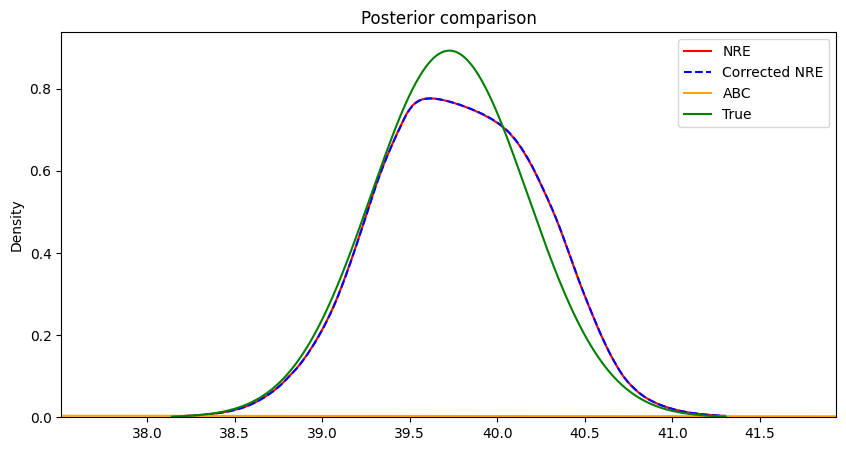

FIGURE CREATED at 


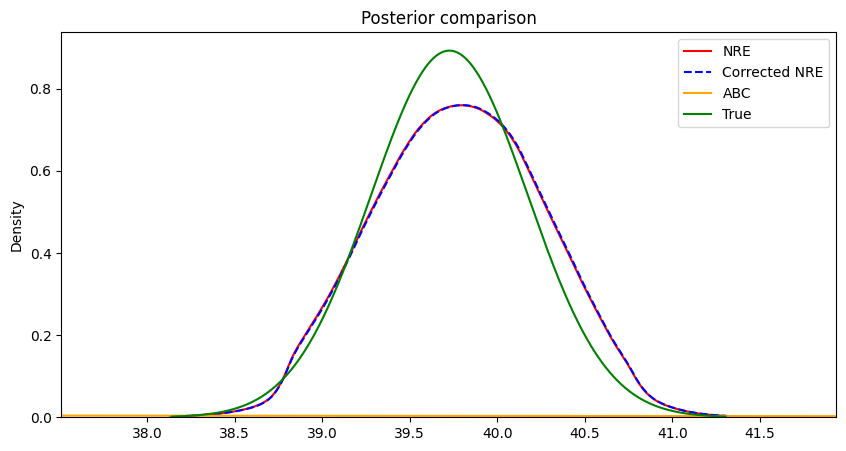

FIGURE CREATED at 


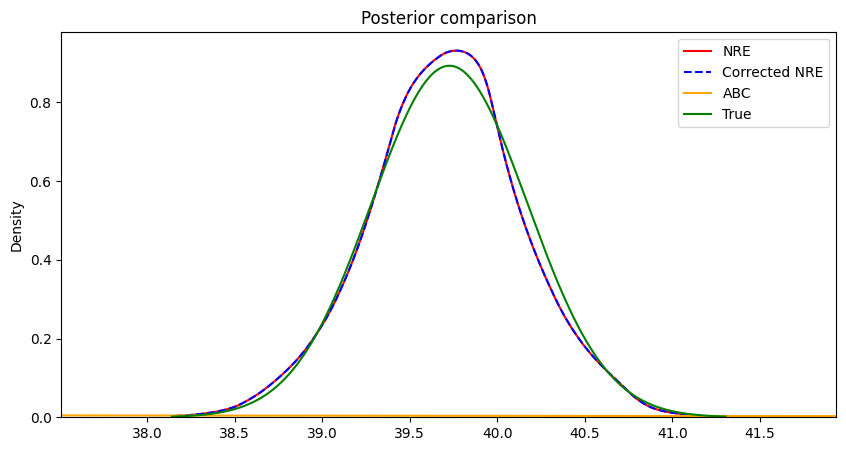

FIGURE CREATED at 


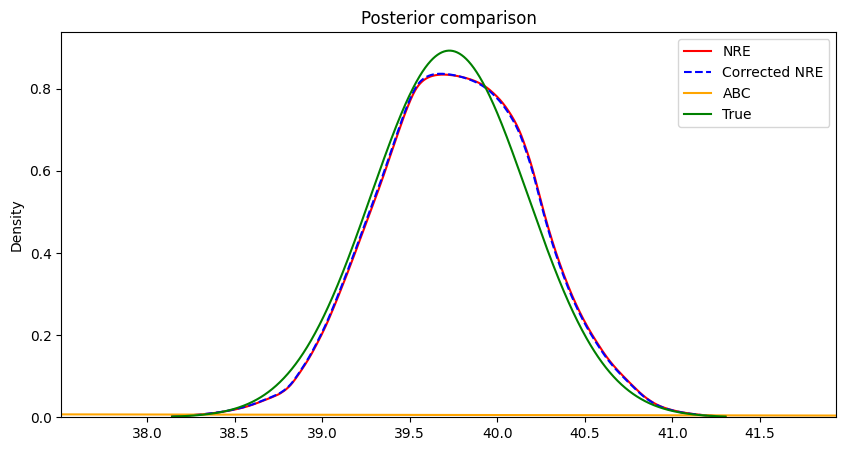

FIGURE CREATED at 


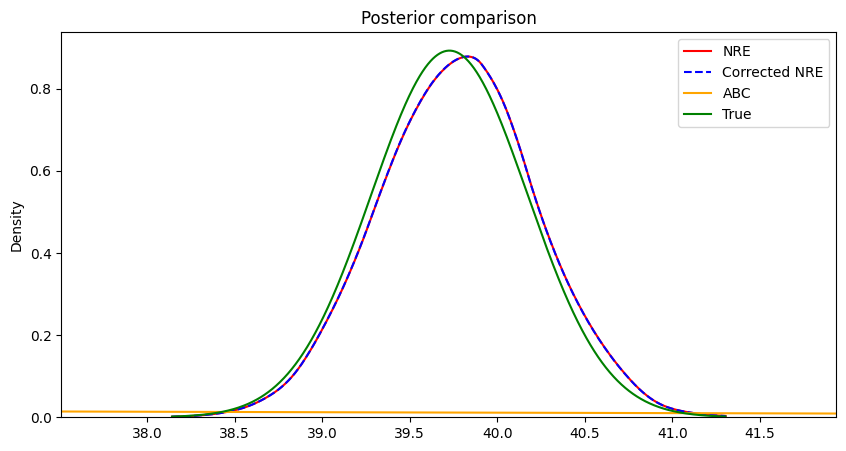

FIGURE CREATED at 


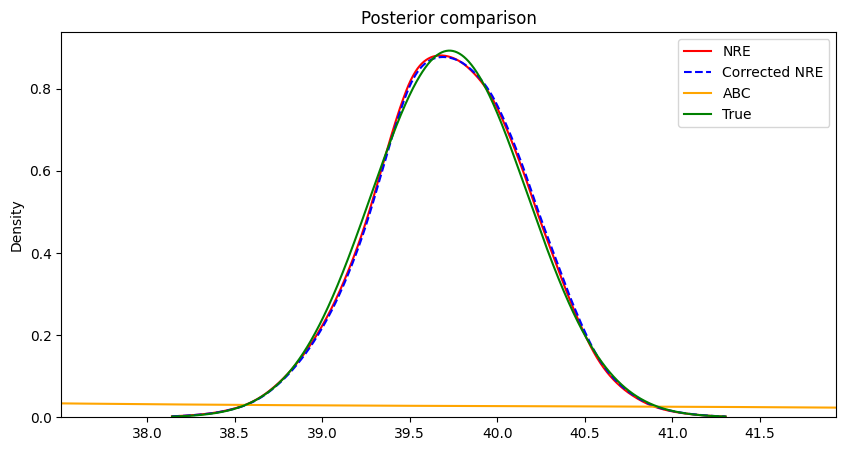

FIGURE CREATED at 


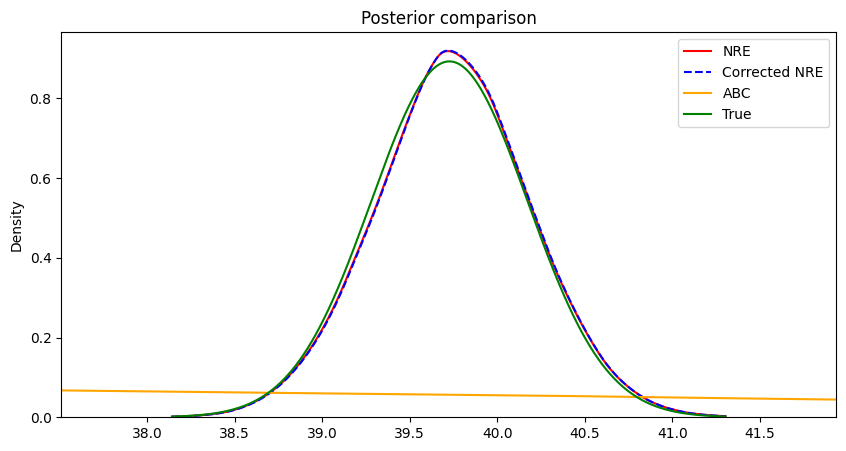

FIGURE CREATED at 


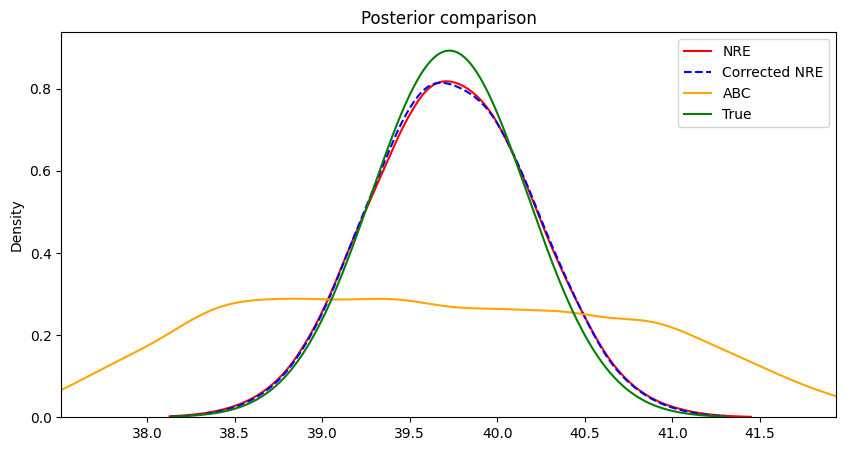

FIGURE CREATED at 


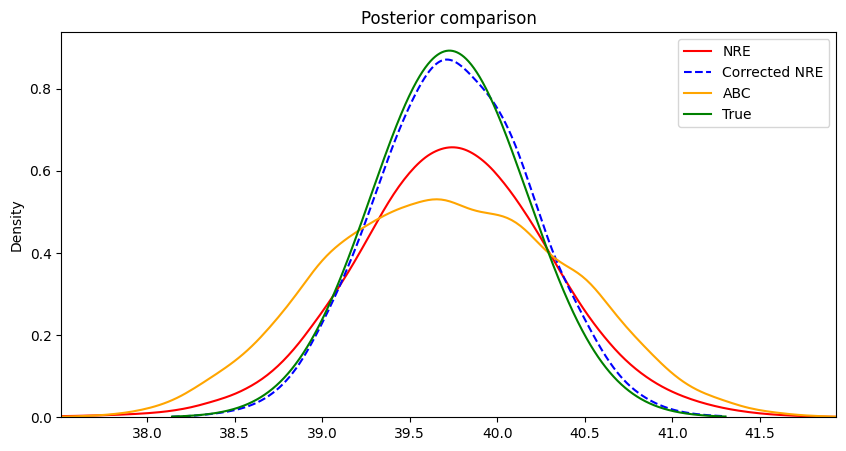

FIGURE CREATED at 


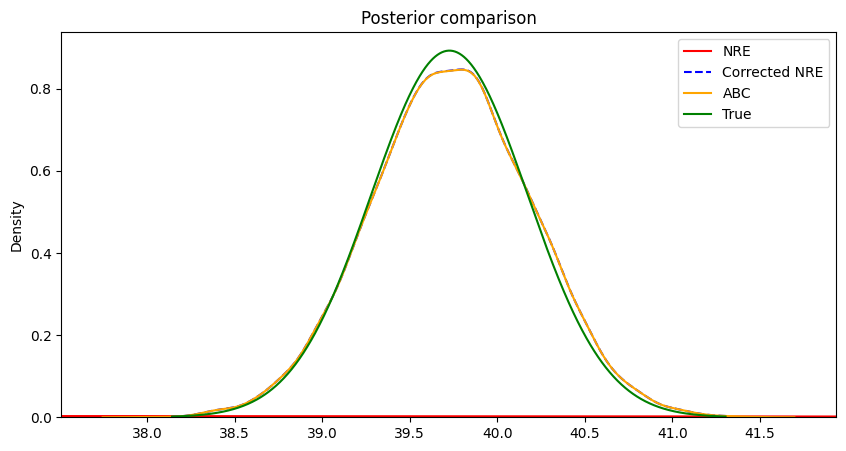

FIGURE CREATED at 


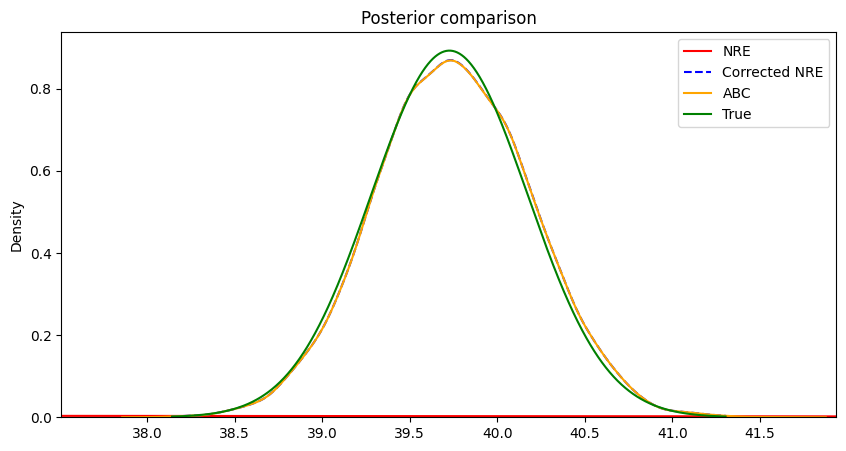

FIGURE CREATED at 


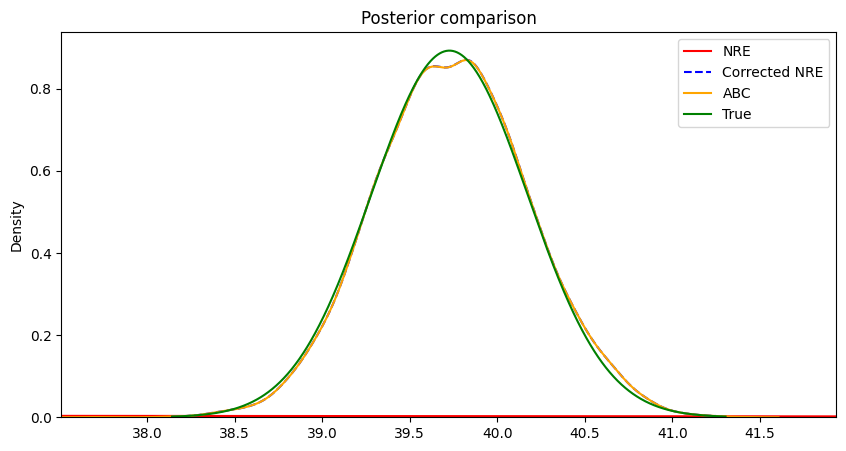

FIGURE CREATED at 


In [7]:
import os
from functions.plots import plot_posterior_comparison 
import scipy.stats as stats
for alpha in alphas: 
    params = PARAMS[alpha]
    thetas_abc = THETAS_ABC[alpha]
    plot_posterior_comparison(params, TRUE_DATA, thetas_abc, PRIOR, "", show = True, true_posterior_pdf=true_posterior_pdf)

# Compute a new metric

The **`eval_metrics`** function in **`functions.metrics`** take a*s* an argument a dictionary of metrics to test of the form \{`metric_name` : `metric_function`\} where metric_function is a function that takes 2 samples as arguments and return the desired metric. 

In [ ]:
from functions.metrics import evaluate_metrics, c2stest, ranksumstest_stat, ranksumstest_pvalue
from jax import random 
metrics_to_test = {"C2ST": c2stest, "RS_stat": ranksumstest_stat, "RS_pvalue": ranksumstest_pvalue}
METRICS = {}
for alpha in alphas:
    params = PARAMS[alpha]
    thetas_abc = THETAS_ABC[alpha]
    METRICS[alpha], time_eval = evaluate_metrics(key = random.PRNGKey(0), metrics_dico = metrics_to_test, params = params, TRUE_DATA = TRUE_DATA, thetas_abc = thetas_abc, PRIOR_DIST = PRIOR, N_GRID = 1000, N_SAMPLE = 1000, N_SAMPLES = 1, N_KDE = 10000, true_posterior_sample=true_posterior_sample)
    print(f"Time evaluation for alpha = {alpha}:", time_eval)

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Evaluation of the metrics...
Time evaluation for alpha = 1.0: 2.925981044769287
Evaluation of the metrics...
Time evaluation for alpha = 0.99: 1.9070889949798584
Evaluation of the metrics...
Time evaluation for alpha = 0.9: 2.3318281173706055
Evaluation of the metrics...
Time evaluation for alpha = 0.75: 1.8524150848388672
Evaluation of the metrics...
Time evaluation for alpha = 0.5: 1.8998899459838867
Evaluation of the metrics...
Time evaluation for alpha = 0.25: 1.628288984298706
Evaluation of the metrics...
